## Gendered Pronoun Resolution

This project aims to address the problem of pronoun resolution. Pronoun resolution involves the task of matching the entity that an expression refers to and is a fundamental part of natural language understanding. However, recent studies have shown that existing core parsers are gender biased. In order to achieve gender balance, Google AI Language introduced the Gendered Ambiguous Pronouns (GAP) dataset. This dataset contains examples of gender-balanced pronouns.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpdLI0Qj2-tbGgZ1nuvo2y4FcZ-CbKZmMr9A&s)

In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gendered-pronoun-resolution/test_stage_1.tsv
/kaggle/input/gendered-pronoun-resolution/sample_submission_stage_2.csv
/kaggle/input/gendered-pronoun-resolution/test_stage_2.tsv
/kaggle/input/gendered-pronoun-resolution/sample_submission_stage_1.csv
/kaggle/input/gap-develop/gap-development.tsv
/kaggle/input/cloudd/cloud.png


## Import Libraries

In [7]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [9]:
df=pd.read_csv('/kaggle/input/gap-develop/gap-development.tsv', sep='\t', skiprows=0)

## EDA

In [32]:
df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [33]:
df.drop('URL',axis=1,inplace=True)

In [34]:
df.isnull().sum()

ID                0
Text              0
Pronoun           0
Pronoun-offset    0
A                 0
A-offset          0
A-coref           0
B                 0
B-offset          0
B-coref           0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2000 non-null   object
 1   Text            2000 non-null   object
 2   Pronoun         2000 non-null   object
 3   Pronoun-offset  2000 non-null   int64 
 4   A               2000 non-null   object
 5   A-offset        2000 non-null   int64 
 6   A-coref         2000 non-null   bool  
 7   B               2000 non-null   object
 8   B-offset        2000 non-null   int64 
 9   B-coref         2000 non-null   bool  
dtypes: bool(2), int64(3), object(5)
memory usage: 129.0+ KB


In [36]:
df['Text']=df['Text'].str.lower()
df['Text']=df['Text'].str.replace("[^\w\s]" , "",regex=True)
df['Text']=df['Text'].str.replace('[\n]', '',regex=True)
df['Text']=df['Text'].str.replace('\d+','',regex=True)
df['Text']=df['Text'].str.replace('\r',' ')

In [37]:
df['Text'][0]

'zoe telford  played the police officer girlfriend of simon maggie dumped by simon in the final episode of series  after he slept with jenny and is not seen again phoebe thomas played cheryl cassidy paulines friend and also a year  pupil in simons class dumped her boyfriend following simons advice after he wouldnt have sex with her but later realised this was due to him catching crabs off her friend pauline'

In [38]:
df['Pronoun'].value_counts()

Pronoun
her    534
his    496
she    249
he     235
She    179
He     138
him     98
Her     38
His     33
Name: count, dtype: int64

## Language Detection

In [40]:
#pip install langdetect

In [41]:
from langdetect import detect

In [42]:
df['lang']=df['Text'].apply(lambda x: detect(x))

In [45]:
df['lang'].value_counts()

lang
en    1999
Name: count, dtype: int64

## WordCloud

In [46]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def wc(data,bgcolor):
    plt.figure(figsize=(8,8))
    mask=np.array(Image.open('/kaggle/input/cloudd/cloud.png'))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

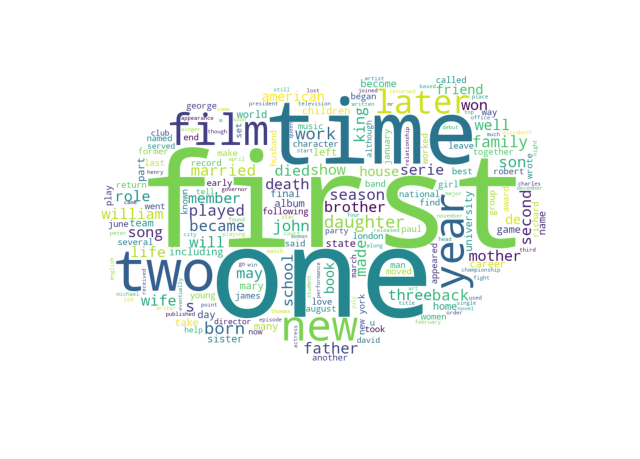

In [48]:
wc(df['Text'],'white')

## Count Vectorizing

In [57]:
from textblob import TextBlob

In [49]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [50]:
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [51]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [52]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2),max_features=10000,analyzer=lemmafn)

## Modelling

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import make_classification

In [54]:
df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,lang
0,development-1,zoe telford played the police officer girlfri...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,en
1,development-2,he grew up in evanston illinois the second old...,His,284,MacKenzie,228,True,Bernard Leach,251,False,en
2,development-3,he had been reelected to congress but resigned...,his,265,Angeloz,173,False,De la Sota,246,True,en
3,development-4,the current members of crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,en
4,development-5,her santa fe opera debut in was as nuria in t...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,en


In [55]:
x=df['Text']
y=df['Pronoun']

In [58]:
x=vect.fit_transform(x)

In [59]:
x_train,x_test,y_train,y_test= train_test_split(x,y, random_state=42,test_size=.20)

In [60]:
r=RandomForestClassifier()
model=r.fit(x_train,y_train)

In [61]:
rpred=r.predict(x_test)
accuracy_score(rpred,y_test)

0.58

In [62]:
print(classification_report(rpred, y_test))

              precision    recall  f1-score   support

          He       0.00      0.00      0.00         1
         Her       0.00      0.00      0.00         0
         His       0.00      0.00      0.00         0
         She       0.25      0.59      0.35        17
          he       0.34      0.62      0.44        26
         her       1.00      0.55      0.71       186
         him       0.00      0.00      0.00         0
         his       0.86      0.59      0.70       154
         she       0.25      0.81      0.38        16

    accuracy                           0.58       400
   macro avg       0.30      0.35      0.29       400
weighted avg       0.84      0.58      0.66       400



In [63]:
confusion_matrix(rpred, y_test)

array([[  0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  10,   0,   0,   0,   0,   6],
       [  6,   0,   0,   0,  16,   0,   3,   1,   0],
       [  0,   4,   0,  26,   4, 102,   3,  14,  33],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 16,   0,   6,   1,  26,   0,  13,  91,   1],
       [  0,   0,   0,   3,   0,   0,   0,   0,  13]])

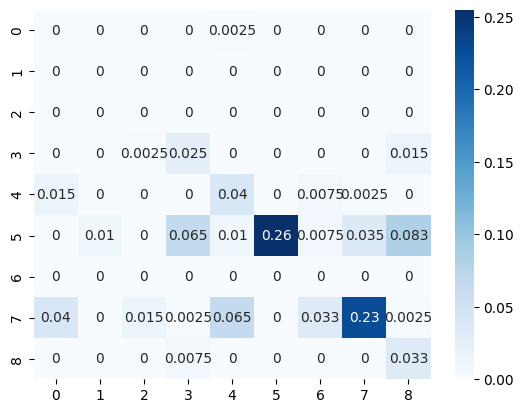

In [64]:
cm = confusion_matrix(rpred, y_test)
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True, cmap='Blues');

In [66]:
#K-Fold Cross Validation
x=df['Text']
y=df['Pronoun']
x=vect.fit_transform(x)

model=RandomForestClassifier()

#K-fold cross validation (K=5)
kf=KFold(n_splits=5, shuffle=True, random_state=42)

#Calculating cross validation results
scores = cross_val_score(model, x, y, cv=kf, scoring='accuracy')

#Average of results
print(f"Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")

Accuracy Scores: [0.5975     0.56       0.595      0.5925     0.55639098]
Mean Accuracy: 0.5802781954887218


In [67]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def algo_test(x, y):
    
    lr = LogisticRegression(max_iter=1000)
    b = BernoulliNB()
    nb = MultinomialNB()
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    abc = AdaBoostClassifier()
    gbc = GradientBoostingClassifier()
    svc = SVC()
    mlp = MLPClassifier(max_iter=1000)

    algos = [lr, b, nb, knn, dt, rf, abc, gbc, svc, mlp]
    algo_names = ['Logistic Regression', 'BernoulliNB', 'MultinomialNB', 'K-Nearest Neighbors',
                  'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM', 'MLP Classifier']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    accuracy = []
    precision = []
    recall = []
    f1 = []

    
    result = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-score'], index=algo_names)
    
    for algo in algos:
        algo.fit(x_train, y_train)
        y_pred = algo.predict(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred, average='weighted'))
        recall.append(recall_score(y_test, y_pred, average='weighted'))
        f1.append(f1_score(y_test, y_pred, average='weighted'))
        
    result['Accuracy'] = accuracy
    result['Precision'] = precision
    result['Recall'] = recall
    result['F1-score'] = f1
    
    
    rtable = result.sort_values('Accuracy', ascending=False)
    return rtable


In [68]:
algo_test(x,y)

,Accuracy,Precision,Recall,F1-score
Gradient Boosting,0.6125,0.595623,0.6125,0.579418
Logistic Regression,0.6100,0.580477,0.6100,0.588288
SVM,0.6100,0.575820,0.6100,0.552031
Random Forest,0.6000,0.577784,0.6000,0.526273
Decision Tree,0.5750,0.575512,0.5750,0.571835
MLP Classifier,0.4975,0.471694,0.4975,0.472903
AdaBoost,0.4850,0.259035,0.4850,0.336537
BernoulliNB,0.4750,0.252814,0.4750,0.326834
MultinomialNB,0.4675,0.412744,0.4675,0.371914
K-Nearest Neighbors,0.2975,0.343714,0.2975,0.286785


## NeatText

In [69]:
x=df['Text']
y=df['Pronoun']

In [21]:
#pip install neattext

In [3]:
import neattext as nt

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC

In [10]:
all=' '.join(df['Text'])

In [11]:
sent=nt.TextFrame(all)

In [12]:
sent.describe()

Key      Value          
Length  : 855847         
vowels  : 254514         
consonants: 417787         
stopwords: 61135          
punctuations: 28072          
special_char: 28134          
tokens(whitespace): 142407         
tokens(words): 145969         


In [13]:
sent.length

855847

In [14]:
sent.readability()

{'automated readability': 17.54685740595982, 'description': None}

In [15]:
x=df['Text']
y=df['Pronoun']

In [16]:
clf=Pipeline([('tfidf',TfidfVectorizer()),('classifier',RandomForestClassifier())])

In [17]:
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=.2, random_state=42)

In [18]:
clf.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [19]:
y_pred=clf.predict(x_test)

In [20]:
accuracy_score(y_pred, y_test)

0.6075

## Summary

The training dataset was read and examined in tsv format. It was analyzed to provide a general understanding of the structure, features and contents of the data. Punctuation marks were removed to reduce unnecessary noise during the training of the model.
Word clouds were used to visualize the data. This visualization helped to identify the most frequently used terms and expressions in the dataset.
The processed data was used for training the model. At this stage, strategies were developed to reduce gender bias. In addition, class balance and confusion matrices were created to evaluate the performance of the model.
Neattext library was used to clean the texts and process the data to be used during the training of the model.
The project was completed with the successful training of the model and the accurate recording of the predictions. This study, which aims to reduce gender bias, makes a significant contribution to the field of natural language processing.

This project prioritizes gender equality and neutrality by addressing the pronoun resolution task. The obtained results provide important information to reduce gender bias and contribute to the natural language processing community. The project has been completed successfully and aims to provide new skills to the participants.